In [4]:
try:
    import torch
except:
    pass
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer
!pip install livelossplot

     |████████████████████████████████| 143kB 2.8MB/s 


In [5]:
## Accelerating neural net training
#!pip uninstall torch
#!curl -s https://course.fast.ai/setup/colab | bash
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [6]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

# build the model
#model = BaselineModel(784, 784, 10)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
import torchbearer
import numpy as np
import matplotlib.pyplot as plt
from torchbearer import callbacks
from torchbearer.callbacks import LiveLossPlot
import pandas as pd
pd.set_option('display.max_columns', None)

In [0]:

def get_metrics(results):

  frame = pd.DataFrame.from_records(results)
  print(frame)
  train_acc_r = frame.acc.to_numpy()
  train_loss_r = frame.loss.to_numpy()
  test_acc_r = frame.val_acc.to_numpy()
  test_loss_r = frame.val_loss.to_numpy()

  return  train_acc_r, train_loss_r, test_acc_r, test_loss_r
  
def run_model(number_of_hidden_units):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  print(f"Device is {device}")
  model = BaselineModel(784, number_of_hidden_units, 10)
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(model.parameters(), lr = 0.01)
  
  callbacks = [LiveLossPlot(skip_first=0, fig_path="livelossplot.png")]

  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, testloader)
  history  = trial.run(epochs=10)
  #results_tr = trial.evaluate(data_key=torchbearer.TRAIN_DATA)
  #results_va = trial.evaluate(data_key=torchbearer.TEST_DATA)
  return history

In [19]:
number_of_nodes = [10, 50, 100, 250, 500, 1000, 5000]
number_of_nodes = [100000]
n = len(number_of_nodes)
results_tr = []
results_val = []
for inx, x in enumerate(number_of_nodes):
  history = run_model(x)
  train_acc_r, train_loss_r, test_acc_r, test_loss_r = get_metrics(history)
  

Device is cuda:0



   running_loss  running_acc      loss       acc  val_loss  val_acc  \
0      0.225663     0.947344  1.608622  0.919333  1.532049   0.9324   
1      0.164706     0.962812  0.163955  0.961517  1.500343   0.9658   
2      0.153987     0.970000  0.144674  0.969100  1.494181   0.9684   
3      0.126215     0.975312  0.113298  0.975683  1.500797   0.9638   
4      0.116827     0.975625  0.100581  0.978800  1.495579   0.9656   
5      0.089306     0.982187  0.082719  0.982800  1.492480   0.9690   
6      0.088332     0.980625  0.076720  0.984300  1.488425   0.9731   
7      0.072541     0.986562  0.069161  0.985767  1.491783   0.9705   
8      0.091545     0.983906  0.076606  0.985700  1.489472   0.9721   
9      0.073343     0.985937  0.065075  0.987850  1.490776   0.9705   

   train_steps  validation_steps  
0          469                79  
1          469                79  
2          469                79  
3          469                79  
4          469                79  
5      

[0.91933334 0.96151668 0.9691     0.97568333 0.9788     0.98280001
 0.98430002 0.98576665 0.98570001 0.98785001]


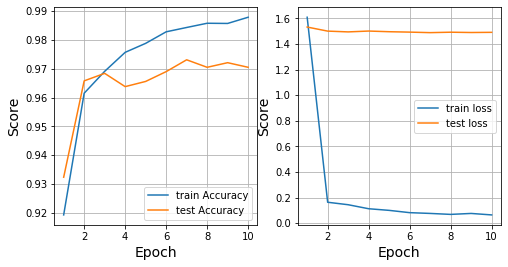

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
x = np.linspace(1,10,10)
print(train_acc_r)
ax[0].plot(x, train_acc_r, label="train Accuracy")
ax[0].plot(x, test_acc_r, label="test Accuracy")
ax[0].grid(True)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].legend()
ax[0].set_ylabel("Score", fontsize=14)

ax[1].plot(x, train_loss_r, label="train loss")
ax[1].plot(x, test_loss_r, label="test loss")
ax[1].grid(True)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].legend()
ax[1].set_ylabel("Score", fontsize=14)

fig.savefig("100000.png")